# symmetric_quantile-normalized_score

## Import necessary packages

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Initialize the ballot set dataframe
This can also be loaded in from a .csv file.

Each row is a voter, each column is a candidate.

In [301]:
""" score_ballot_dictionary = {
    'EVELYN': [33, 13, 71, 32, 25, 27, 27, 32, 56, 77, 44, 20],
    'FRANK': [42, 84, 50, 81, 43, 28, 97, 59, 2, 59, 99, 85],
    'GEORGIA': [13, 94, 2, 87, 94, 96, 27, 19, 23, 66, 50, 21],
    'HAROLD': [0, 104, 2, 2, 0, 3, 8, 7, 100, 5, 8, 9]
} """

# In this example, the first column represents a Condorcet winner, but they will lose to the second column candidate under standard score voting.
score_ballot_dictionary = {
    'EVELYN':   [1, 0,  0, 10],
    'FRANK':    [1, 10, 0,  0],
    'GEORGIA':  [10, 9, 0,  0]
}
# symmetric quantile-normalization, in contrast, will naturally select the Condorcet winner.

score_ballot_df = pd.DataFrame(score_ballot_dictionary).T
#score_ballot_df = score_ballot_df.drop(10, axis=1)
score_ballot_df.columns = range(len(score_ballot_df.columns))
score_ballot_df

,0,1,2,3
EVELYN,1,0,0,10
FRANK,1,10,0,0
GEORGIA,10,9,0,0
HAROLD,10,9,0,0
ISABEL,1,10,0,0
JACK,1,0,0,10


## Define auxiliary functions to linearly scale score ballots to span a pre-defined range.

Include a default case when a ballot has no variation.

In [302]:
def get_scaled_score_ballot(score_ballot, min=0, max=1):
    score_ballot = score_ballot
    max_score = np.max(score_ballot)
    min_score = np.min(score_ballot)

    score_range = max_score - min_score
    mid_score = (min+max)/2
    #print("score range: ", score_range)

    if score_range == 0:
        scaled_score_ballot = [mid_score for _ in score_ballot]
    else:
        scaled_score_ballot = [min+max*(score - min_score)/score_range for score in score_ballot]
    return scaled_score_ballot

def get_scaled_score_ballot_df(score_ballot_df, min=0, max=1):
    scaled_score_ballot_df = score_ballot_df.copy(deep=True)

    for index, score_ballot_row in score_ballot_df.iterrows():
        this_score_ballot = score_ballot_row.values
        #print(this_score_ballot)
        scaled_scores = get_scaled_score_ballot(this_score_ballot, min, max)
        scaled_score_ballot_df.loc[index] = scaled_scores  # Update the row in the DataFrame

    return scaled_score_ballot_df

scaled_score_ballot_df = get_scaled_score_ballot_df(score_ballot_df)
scaled_score_ballot_df

,0,1,2,3
EVELYN,0.1,0.0,0.0,1.0
FRANK,0.1,1.0,0.0,0.0
GEORGIA,1.0,0.9,0.0,0.0
HAROLD,1.0,0.9,0.0,0.0
ISABEL,0.1,1.0,0.0,0.0
JACK,0.1,0.0,0.0,1.0


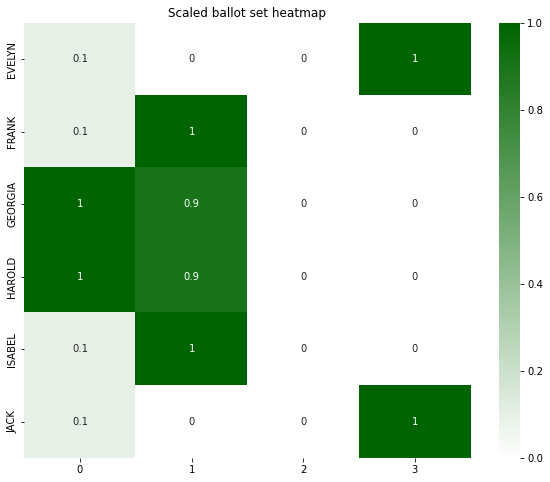

In [303]:
# Create a custom colormap
# This example uses blue, but you can change 'blue' to any color of your choice.
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_score_ballot_df, cmap=single_color_cmap, annot=True)
plt.title('Scaled ballot set heatmap')
plt.show()

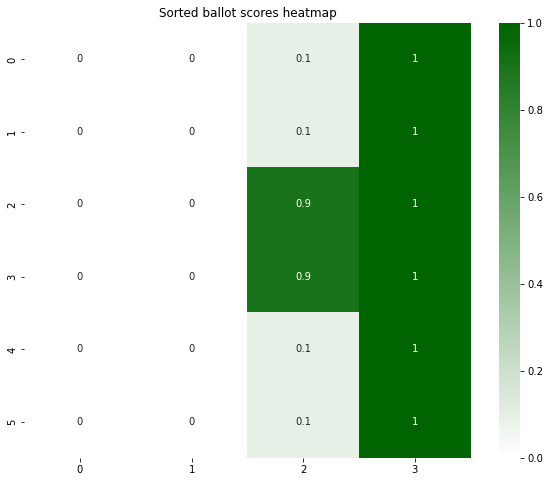

In [304]:
sorted_scaled_score_matrix = np.sort(scaled_score_ballot_df, axis=1)
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_scaled_score_matrix, cmap=single_color_cmap, annot=True)
plt.title('Sorted ballot scores heatmap')
plt.show()

## Define a function to compute the asymmetric quantile normalized score values.

In [305]:
def get_quantile_normalized_values(score_ballot_df):
    # Sort the values in each column
    score_ballot_df = score_ballot_df.T
    sorted_df = np.sort(score_ballot_df, axis=0)
    
    # Calculate the mean of each row across the sorted columns
    mean_values = np.mean(sorted_df, axis=1)
    
    # Rank the values in the original dataframe
    ranks = score_ballot_df.stack().groupby(score_ballot_df.rank(method='min').stack().astype(int)).mean()
    
    # Replace ranks with mean values
    #normalized_df = score_ballot_df.rank(method='min').stack().astype(int).map(ranks).unstack()
    #print(list(mean_values))
    return list(mean_values)

get_quantile_normalized_values(scaled_score_ballot_df)


[0.0, 0.0, 0.3666666666666667, 1.0]

## Simply combine the linear scaling to compute asymmetric quantile normalized values over scaled ballots.

In [306]:

def get_quantile_normalized_scaled_values(score_ballot_df, min=0, max=1):
    scaled_score_ballot_df = get_scaled_score_ballot_df(score_ballot_df, min, max)
    return np.array(get_quantile_normalized_values(scaled_score_ballot_df))

get_quantile_normalized_scaled_values(score_ballot_df)


array([0.        , 0.        , 0.36666667, 1.        ])

## Define a simple function to transform the asymmetric quantile normalized values into a symmetric version that preserves cancellation properties.

[0.0, 0.31666666666666665, 0.6833333333333333, 1.0]


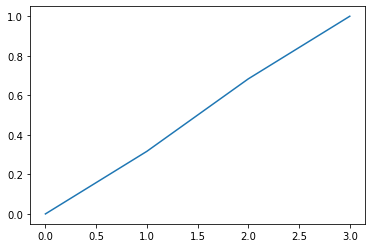

In [307]:
def get_symmetric_scaled_quantile_normalized_values(score_ballot_df, min=0, max=1):
    scaled_quantile_normalized_values = get_quantile_normalized_scaled_values(score_ballot_df, min, max)

    num_values = len(scaled_quantile_normalized_values)

    symmetric_scaled_quantile_normalized_values = [(scaled_quantile_normalized_values[k] + (max-scaled_quantile_normalized_values[(num_values -1) - k]))/2 for k in range(num_values)]

    return symmetric_scaled_quantile_normalized_values

symmetric_scaled_quantile_normalized_values=get_symmetric_scaled_quantile_normalized_values(score_ballot_df)
plt.plot(symmetric_scaled_quantile_normalized_values)
print(symmetric_scaled_quantile_normalized_values)

## Modify ordinary quantile normalization by replacing asymmetric quantile values with their symmetrical adjusted values.

Adjustments are also made to account for repeated values. When values are tied in rank, they are assigned the mean of the values corresponding to the ranks they would normally represent if they were different. This still preserves symmetry and hence the desired cancellation properties.

In [308]:
def get_symmetric_scaled_quantile_normalized_score_ballot_df(score_ballot_df, min=0, max=1):
    #print(score_ballot_df)
    # Rank the values in each column
    symmetric_scaled_quantile_normalized_score_values = get_symmetric_scaled_quantile_normalized_values(score_ballot_df, min, max)
    #print((symmetric_scaled_quantile_normalized_score_values))
    #print('\n')

    #print("\nOriginal score ballots:\n", score_ballot_df)

    score_rankings_df = score_ballot_df.rank(axis=1, method='first').astype(int) -1
    #print("\nScore ranking ballots:\n ", score_rankings_df)
    #print('\n')
    #print(score_ballot_df)

    as_if_unique_normalized_df = score_rankings_df.applymap(lambda x: symmetric_scaled_quantile_normalized_score_values[x])
    #print("\nNormalized as if scores are unique:\n ", as_if_unique_normalized_df)

    corrected_df = as_if_unique_normalized_df.copy()

    for index, row in score_ballot_df.iterrows():
        # Get the scores and their corresponding ranks from the original dataframe
        scores_with_ranks = row.rank(method='min').astype(int) -1
        #print("scores with ranks: ", scores_with_ranks.values)
        unique_scores = row.unique()
        
        for score in unique_scores:
            # Find the ranks (indices) associated with this score
            ranks_for_score = scores_with_ranks[row == score].values
            # Calculate the average of the symmetric scaled values for these ranks
            avg_value = as_if_unique_normalized_df.loc[index, ranks_for_score].mean()
            # Assign this average back to the corresponding locations in the corrected dataframe
            corrected_df.loc[index, ranks_for_score] = avg_value

    return corrected_df

symmetric_scaled_quantile_normalized_score_ballot_df=get_symmetric_scaled_quantile_normalized_score_ballot_df(score_ballot_df)
print("Symmetric quantile-normalized score ballot set: \n")
symmetric_scaled_quantile_normalized_score_ballot_df
#print(score_ballot_df)

Symmetric quantile-normalized score ballot set: 



,0,1,2,3
EVELYN,0.683333,0.000000,0.316667,1.000000
FRANK,0.683333,1.000000,0.000000,0.316667
GEORGIA,1.000000,0.683333,0.000000,0.316667
HAROLD,1.000000,0.683333,0.000000,0.316667
ISABEL,0.683333,1.000000,0.000000,0.316667
JACK,0.683333,0.000000,0.316667,1.000000


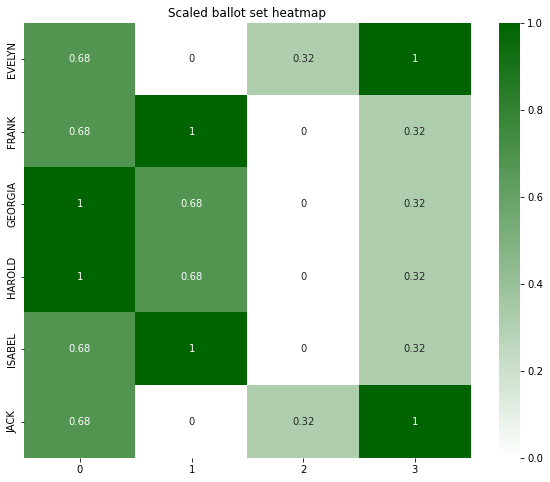

In [309]:
# Create a custom colormap
# This example uses blue, but you can change 'blue' to any color of your choice.
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(symmetric_scaled_quantile_normalized_score_ballot_df, cmap=single_color_cmap, annot=True)
plt.title('Scaled ballot set heatmap')
plt.show()

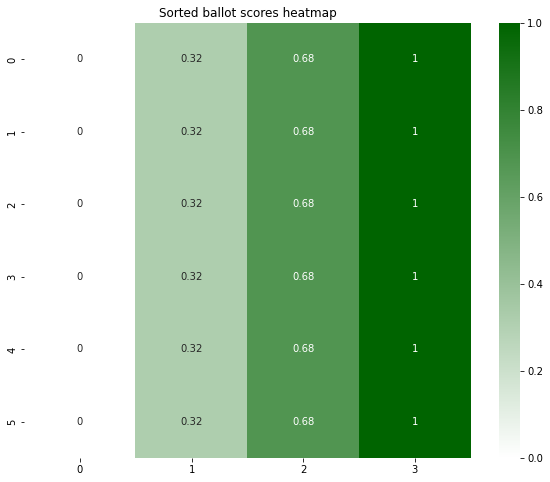

In [310]:
sorted_scaled_score_matrix = np.sort(symmetric_scaled_quantile_normalized_score_ballot_df, axis=1)
single_color_cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkgreen'])

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_scaled_score_matrix, cmap=single_color_cmap, annot=True)
plt.title('Sorted ballot scores heatmap')
plt.show()

## Compare with original scaled score ballot set.

In [311]:
scaled_score_ballot_df

,0,1,2,3
EVELYN,0.1,0.0,0.0,1.0
FRANK,0.1,1.0,0.0,0.0
GEORGIA,1.0,0.9,0.0,0.0
HAROLD,1.0,0.9,0.0,0.0
ISABEL,0.1,1.0,0.0,0.0
JACK,0.1,0.0,0.0,1.0


## Observe the election results by tallying symmetric quantile-normalized score values for each candidate.

Here an average is computed.

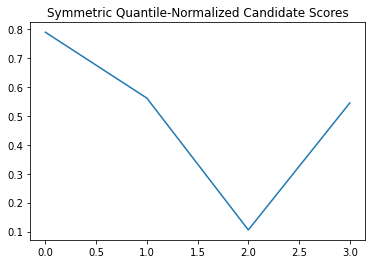

In [312]:
column_averages = symmetric_scaled_quantile_normalized_score_ballot_df.mean(axis=0)
column_averages
plt.plot(column_averages)
plt.title('Symmetric Quantile-Normalized Candidate Scores')
plt.show()

## Compare with result from scaled score ballot set.

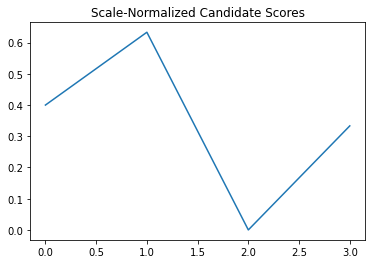

In [313]:
column_averages = scaled_score_ballot_df.mean(axis=0)
column_averages
plt.plot(column_averages)
plt.title('Scale-Normalized Candidate Scores')
plt.show()